## Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
import sklearn.metrics as m
import xgboost as xgb
import warnings
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import log_loss,cohen_kappa_score
from imblearn.metrics import geometric_mean_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import dataset

In [2]:
df=pd.read_csv('/content/drive/MyDrive/CICIDS2017.csv')

## Preprocessing

In [3]:
df.fillna(0,inplace=True)

In [4]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [5]:
df[' Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

Normal: Benign

Botnet ARES: Bot

Brute Force: FTP-Patator, SSH-Patator

Dos/DDos:
DDoS, DoS GoldenEye, DoS Hulk, DoS Slowhttptest, DoS slowloris, Heartbleed

Web Attack: Web Attack � Brute Force, Web Attack � Sql Injection, Web Attack � XSS


In [4]:
df[' Label'].replace(['BENIGN'],'Normal',inplace=True)
df[' Label'].replace(['Bot'],'Botnet ARES',inplace=True)
df[' Label'].replace(['FTP-Patator', 'SSH-Patator'],'Brute Force',inplace=True)
df[' Label'].replace(['DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'Heartbleed'],'Dos/DDos',inplace=True)
df[' Label'].replace(['Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS'],'Web Attack',inplace=True)

In [9]:
df[' Label'].value_counts()

Normal          2273097
Dos/DDos         380699
PortScan         158930
Brute Force       13835
Web Attack         2180
Botnet ARES        1966
Infiltration         36
Name:  Label, dtype: int64

In [5]:
df=df[df[' Label'] != 'Infiltration']

In [8]:
df[' Label'].value_counts()

Normal         2273097
Dos/DDos        380699
PortScan        158930
Brute Force      13835
Web Attack        2180
Botnet ARES       1966
Name:  Label, dtype: int64

In [6]:
data = df.copy()

for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)

    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)

attackType = data[' Label'].unique()
data[' Label'] = data[' Label'].astype('category')
data[' Label'] = data[' Label'].astype("category").cat.codes

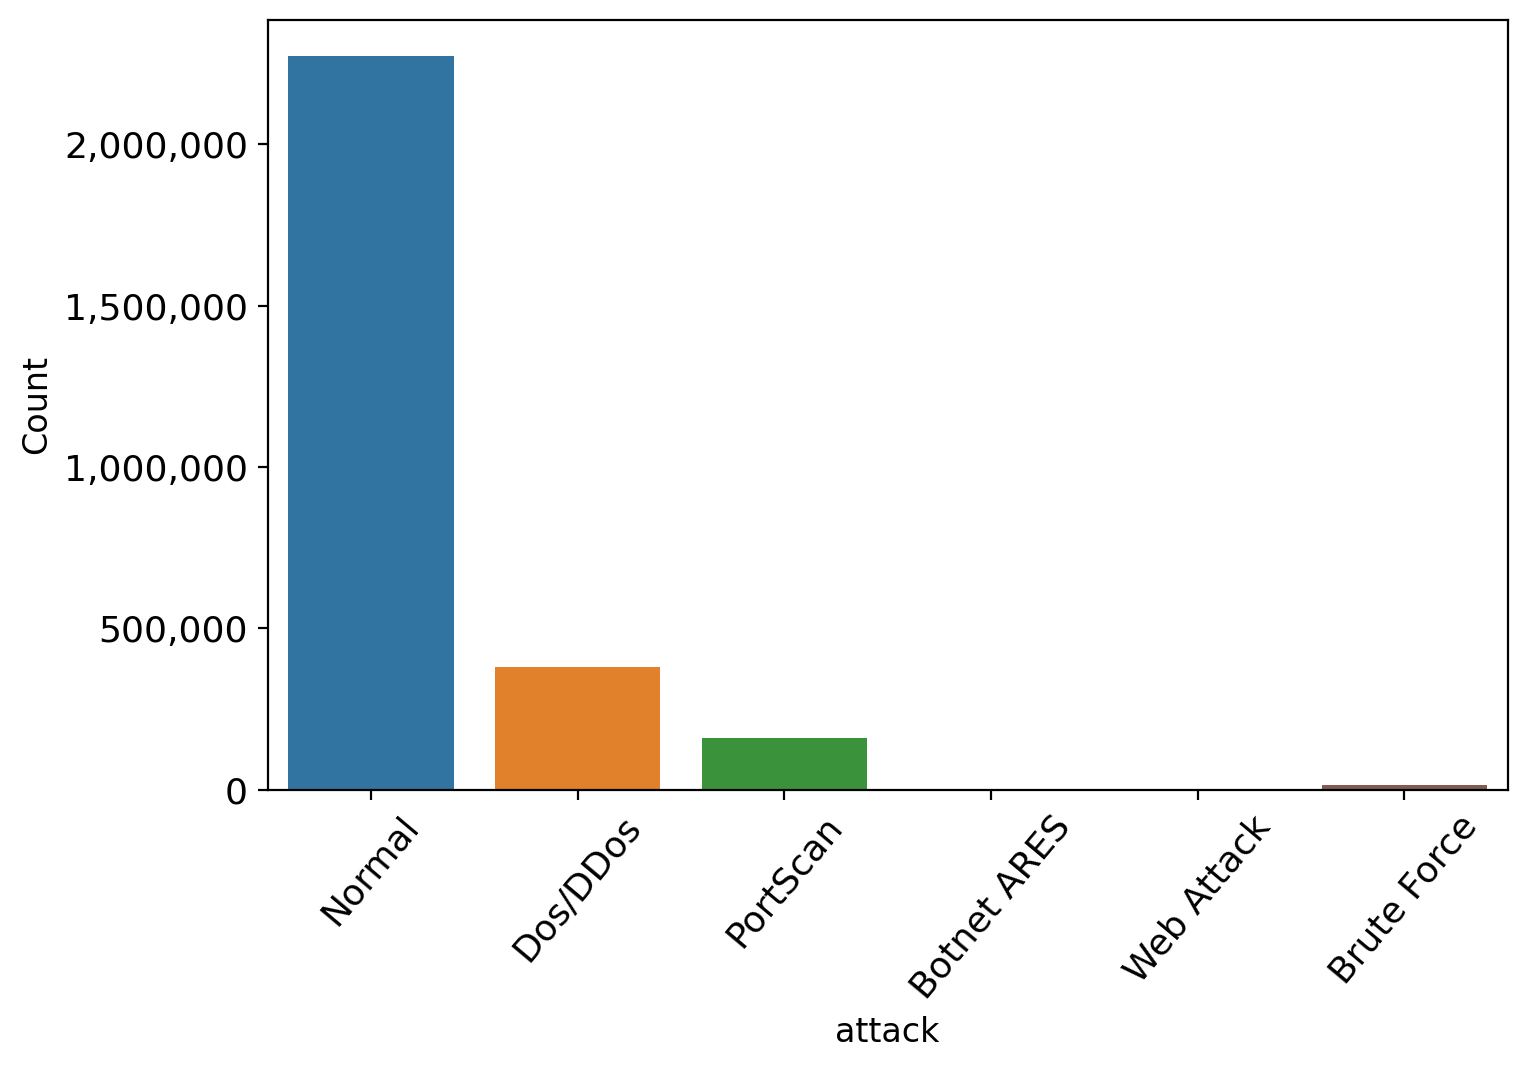

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as tkr
def func(x, pos):  # formatter function takes tick label and tick position
    s = '%d' % x
    groups = []
    while s and s[-1].isdigit():
        groups.append(s[-3:])
        s = s[:-3]
    return s + ','.join(reversed(groups))

y_format = tkr.FuncFormatter(func)  # make formatter
plt.figure(figsize=(8,5), dpi = 200)
p=sns.countplot(x=' Label',data= df )
p.yaxis.set_major_formatter(y_format)
p.tick_params(labelsize=13)
plt.xticks(rotation = 50)
plt.xlabel("attack",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.show()

## Data spliting

In [7]:
data.replace([np.inf, -np.inf], 0, inplace=True)

In [36]:
y = data[' Label']
X = data.drop([' Label'],axis=1)

In [37]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2, random_state=0,shuffle=True)

## Results with origional featurs

In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=10, solver='lbfgs',max_iter=5,multi_class='auto',C=1.0)
start = time.time()
clf.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
dtP3=clf.predict(X_test)
print('accuracy score',accuracy_score(Y_test,dtP3))
print('error rate:',1-accuracy_score(Y_test,dtP3))
print(classification_report(Y_test,dtP3))
# kf = KFold(n_splits=5, shuffle=True)
# clf = LogisticRegression(random_state=10, solver='lbfgs',max_iter=5,multi_class='auto',C=1.0)
# score = cross_val_score(clf, X, y, cv= kf, scoring="accuracy")
# print("%0.4f accuracy with a standard deviation of %0.4f" % (score.mean(), score.std()))
cf_matrix=confusion_matrix(Y_test,dtP3)
cf_matrix

Training time: 36.31540322303772s
accuracy score 0.8510426712732848
error rate: 0.1489573287267152
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.00      0.00      0.00      2731
           2       0.71      0.60      0.65     75912
           3       0.87      0.96      0.91    455122
           4       0.00      0.00      0.00     31553
           5       0.00      0.00      0.00       436

    accuracy                           0.85    566142
   macro avg       0.26      0.26      0.26    566142
weighted avg       0.79      0.85      0.82    566142



array([[     0,      0,      7,    381,      0,      0],
       [     0,      0,      0,   2731,      0,      0],
       [     0,      0,  45597,  30315,      0,      0],
       [     0,      0,  18887, 436214,      0,     21],
       [     0,      0,      8,  31545,      0,      0],
       [     0,      0,      0,    436,      0,      0]])

In [15]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
clf = RandomForestClassifier(n_estimators=2,max_depth=2, random_state=100,criterion='entropy')
start = time.time()
clf.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
dtP3=clf.predict(X_test)
print('accuracy score',accuracy_score(Y_test,dtP3))
print('error rate:',1-accuracy_score(Y_test,dtP3))
print(classification_report(Y_test,dtP3))
# kf = KFold(n_splits=10, shuffle=True)
# clf = RandomForestClassifier(n_estimators=20,max_depth=5, random_state=100,criterion='entropy')
# score = cross_val_score(clf, x, y, cv= kf, scoring="accuracy")
# print("%0.4f accuracy with a standard deviation of %0.4f" % (score.mean(), score.std()))
cf_matrix=confusion_matrix(Y_test,dtP3)
cf_matrix

RF
Training time: 10.16725206375122s
accuracy score 0.8842145610111951
error rate: 0.11578543898880489
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.00      0.00      0.00      2731
           2       0.98      0.61      0.75     75912
           3       0.88      1.00      0.93    455122
           4       0.00      0.00      0.00     31553
           5       0.00      0.00      0.00       436

    accuracy                           0.88    566142
   macro avg       0.31      0.27      0.28    566142
weighted avg       0.84      0.88      0.85    566142



array([[     0,      0,      0,    388,      0,      0],
       [     0,      0,      0,   2731,      0,      0],
       [     0,      0,  46257,  29655,      0,      0],
       [     0,      0,    788, 454334,      0,      0],
       [     0,      0,      9,  31544,      0,      0],
       [     0,      0,      2,    434,      0,      0]])

In [10]:
from sklearn.naive_bayes import GaussianNB
print("GNB")
clf = GaussianNB()
start = time.time()
clf.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
dtP3=clf.predict(X_test)
print('accuracy score',accuracy_score(Y_test,dtP3))
print('error rate:',1-accuracy_score(Y_test,dtP3))
print(classification_report(Y_test,dtP3))
# kf = KFold(n_splits=10, shuffle=True)
# clf = GaussianNB()
# score = cross_val_score(clf, x, y, cv= kf, scoring="accuracy")
# print("%0.4f accuracy with a standard deviation of %0.4f" % (score.mean(), score.std()))
cf_matrix=confusion_matrix(Y_test,dtP3)
cf_matrix

GNB
Training time: 3.5147595405578613s
accuracy score 0.15734038456782928
error rate: 0.8426596154321707
              precision    recall  f1-score   support

           0       0.00      0.89      0.01       388
           1       0.01      1.00      0.02      2731
           2       0.43      0.74      0.55     75912
           3       1.00      0.06      0.12    455122
           4       0.00      0.00      0.00     31553
           5       0.02      0.91      0.04       436

    accuracy                           0.16    566142
   macro avg       0.24      0.60      0.12    566142
weighted avg       0.86      0.16      0.17    566142



array([[   347,     38,      0,      1,      1,      1],
       [     2,   2721,      0,      0,      6,      2],
       [  1036,  16714,  56435,    119,     61,   1547],
       [ 86917, 190603,  73914,  29178,  59308,  15202],
       [  8030,  23361,     52,      9,      0,    101],
       [     0,     36,      2,      2,      0,    396]])

In [38]:
from sklearn.tree import DecisionTreeClassifier
print("DT")
clf=DecisionTreeClassifier(max_depth=2,random_state=500,criterion='entropy')
start = time.time()
clf.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
dtP3=clf.predict(X_test)
print('accuracy score',accuracy_score(Y_test,dtP3))
print('error rate:',1-accuracy_score(Y_test,dtP3))
print(classification_report(Y_test,dtP3))
# kf = KFold(n_splits=10, shuffle=True)
# clf=DecisionTreeClassifier(max_depth=5,random_state=500,criterion='entropy')
# score = cross_val_score(clf, x, y, cv= kf, scoring="accuracy")
# print("%0.4f accuracy with a standard deviation of %0.4f" % (score.mean(), score.std()))
cf_matrix=confusion_matrix(Y_test,dtP3)
cf_matrix

DT
Training time: 26.611921787261963s
accuracy score 0.888692236223421
error rate: 0.11130776377657903
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.00      0.00      0.00      2731
           2       1.00      0.63      0.77     75912
           3       0.88      1.00      0.94    455122
           4       0.00      0.00      0.00     31553
           5       0.00      0.00      0.00       436

    accuracy                           0.89    566142
   macro avg       0.31      0.27      0.29    566142
weighted avg       0.84      0.89      0.86    566142



array([[     0,      0,      0,    388,      0,      0],
       [     0,      0,      0,   2731,      0,      0],
       [     0,      0,  48043,  27869,      0,      0],
       [     0,      0,     39, 455083,      0,      0],
       [     0,      0,      9,  31544,      0,      0],
       [     0,      0,      2,    434,      0,      0]])

# Reuslts with propopsed features

In [12]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
RF=RandomForestClassifier(n_estimators=20,max_depth=20, random_state=0)
rfPre1=RF.fit(X, y).predict_proba(X)
rf=pd.DataFrame(rfPre1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(rf,y,test_size = 0.2,random_state=0,shuffle=True)

RF


In [28]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=10, solver='lbfgs',max_iter=6,multi_class='auto',C=1.0)
start = time.time()
clf.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
dtP3=clf.predict(X_test)
print('accuracy score',accuracy_score(Y_test,dtP3))
print('error rate:',1-accuracy_score(Y_test,dtP3))
print(classification_report(Y_test,dtP3))
kf = KFold(n_splits=5, shuffle=True)
clf = LogisticRegression(random_state=10, solver='lbfgs',max_iter=6,multi_class='auto',C=1.0)
score = cross_val_score(clf, rf, y, cv= kf, scoring="accuracy")
print("%0.4f accuracy with a standard deviation of %0.4f" % (score.mean(), score.std()))
cf_matrix=confusion_matrix(Y_test,dtP3)
cf_matrix

Training time: 4.845222473144531s
accuracy score 0.9930035220845653
error rate: 0.0069964779154346735
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.00      0.00      0.00      2731
           2       1.00      1.00      1.00     75912
           3       0.99      1.00      1.00    455122
           4       1.00      1.00      1.00     31553
           5       0.00      0.00      0.00       436

    accuracy                           0.99    566142
   macro avg       0.50      0.50      0.50    566142
weighted avg       0.99      0.99      0.99    566142

0.9930 accuracy with a standard deviation of 0.0001


array([[     0,      0,      0,    388,      0,      0],
       [     0,      0,      0,   2731,      0,      0],
       [     0,      0,  75748,    164,      0,      0],
       [     0,      0,     74, 454894,    154,      0],
       [     0,      0,      6,      8,  31539,      0],
       [     0,      0,      0,    436,      0,      0]])

In [30]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
clf = RandomForestClassifier(n_estimators=5,max_depth=5, random_state=100,criterion='entropy')
start = time.time()
clf.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
dtP3=clf.predict(X_test)
print('accuracy score',accuracy_score(Y_test,dtP3))
print('error rate:',1-accuracy_score(Y_test,dtP3))
print(classification_report(Y_test,dtP3))
kf = KFold(n_splits=5, shuffle=True)
clf = RandomForestClassifier(n_estimators=5,max_depth=5, random_state=100,criterion='entropy')
score = cross_val_score(clf, rf, y, cv= kf, scoring="accuracy")
print("%0.4f accuracy with a standard deviation of %0.4f" % (score.mean(), score.std()))
cf_matrix=confusion_matrix(Y_test,dtP3)
cf_matrix

RF
Training time: 7.247641086578369s
accuracy score 0.9992546039686157
error rate: 0.0007453960313843488
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       388
           1       1.00      1.00      1.00      2731
           2       1.00      1.00      1.00     75912
           3       1.00      1.00      1.00    455122
           4       0.99      1.00      1.00     31553
           5       0.99      0.99      0.99       436

    accuracy                           1.00    566142
   macro avg       0.99      0.99      0.99    566142
weighted avg       1.00      1.00      1.00    566142

0.9993 accuracy with a standard deviation of 0.0001


array([[   372,      0,      0,     16,      0,      0],
       [     0,   2731,      0,      0,      0,      0],
       [     0,      0,  75843,     66,      0,      3],
       [    21,      1,    116, 454797,    187,      0],
       [     0,      0,      5,      1,  31547,      0],
       [     0,      0,      1,      5,      0,    430]])

In [32]:
from sklearn.naive_bayes import GaussianNB
print("GNB")
clf = GaussianNB(var_smoothing=3)
start = time.time()
clf.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
dtP3=clf.predict(X_test)
print('accuracy score',accuracy_score(Y_test,dtP3))
print('error rate:',1-accuracy_score(Y_test,dtP3))
print(classification_report(Y_test,dtP3))
kf = KFold(n_splits=5, shuffle=True)
clf = GaussianNB(var_smoothing=3)
score = cross_val_score(clf, rf, y, cv= kf, scoring="accuracy")
print("%0.4f accuracy with a standard deviation of %0.4f" % (score.mean(), score.std()))
cf_matrix=confusion_matrix(Y_test,dtP3)
cf_matrix

GNB
Training time: 0.6069135665893555s
accuracy score 0.9358040915530026
error rate: 0.06419590844699741
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.00      0.00      0.00      2731
           2       1.00      0.98      0.99     75912
           3       0.93      1.00      0.96    455122
           4       0.00      0.00      0.00     31553
           5       0.00      0.00      0.00       436

    accuracy                           0.94    566142
   macro avg       0.32      0.33      0.33    566142
weighted avg       0.88      0.94      0.91    566142

0.9354 accuracy with a standard deviation of 0.0003


array([[     0,      0,      0,    388,      0,      0],
       [     0,      0,      0,   2731,      0,      0],
       [     0,      0,  74679,   1233,      0,      0],
       [     0,      0,      3, 455119,      0,      0],
       [     0,      0,      0,  31553,      0,      0],
       [     0,      0,      0,    436,      0,      0]])

In [33]:
from sklearn.tree import DecisionTreeClassifier
print("DT")
clf=DecisionTreeClassifier(max_depth=2,random_state=500,criterion='entropy')
start = time.time()
clf.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
dtP3=clf.predict(X_test)
print('accuracy score',accuracy_score(Y_test,dtP3))
print('error rate:',1-accuracy_score(Y_test,dtP3))
print(classification_report(Y_test,dtP3))
kf = KFold(n_splits=5, shuffle=True)
clf=DecisionTreeClassifier(max_depth=2,random_state=500,criterion='entropy')
score = cross_val_score(clf, rf, y, cv= kf, scoring="accuracy")
print("%0.4f accuracy with a standard deviation of %0.4f" % (score.mean(), score.std()))
cf_matrix=confusion_matrix(Y_test,dtP3)
cf_matrix

DT
Training time: 1.6160049438476562s
accuracy score 0.9930211854976313
error rate: 0.006978814502368702
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.00      0.00      0.00      2731
           2       1.00      1.00      1.00     75912
           3       1.00      1.00      1.00    455122
           4       0.89      1.00      0.94     31553
           5       0.00      0.00      0.00       436

    accuracy                           0.99    566142
   macro avg       0.48      0.50      0.49    566142
weighted avg       0.99      0.99      0.99    566142

0.9930 accuracy with a standard deviation of 0.0001


array([[     0,      0,      0,     37,    351,      0],
       [     0,      0,      0,      1,   2730,      0],
       [     0,      0,  75847,     62,      3,      0],
       [     0,      0,    116, 454798,    208,      0],
       [     0,      0,      6,      1,  31546,      0],
       [     0,      0,      0,      5,    431,      0]])

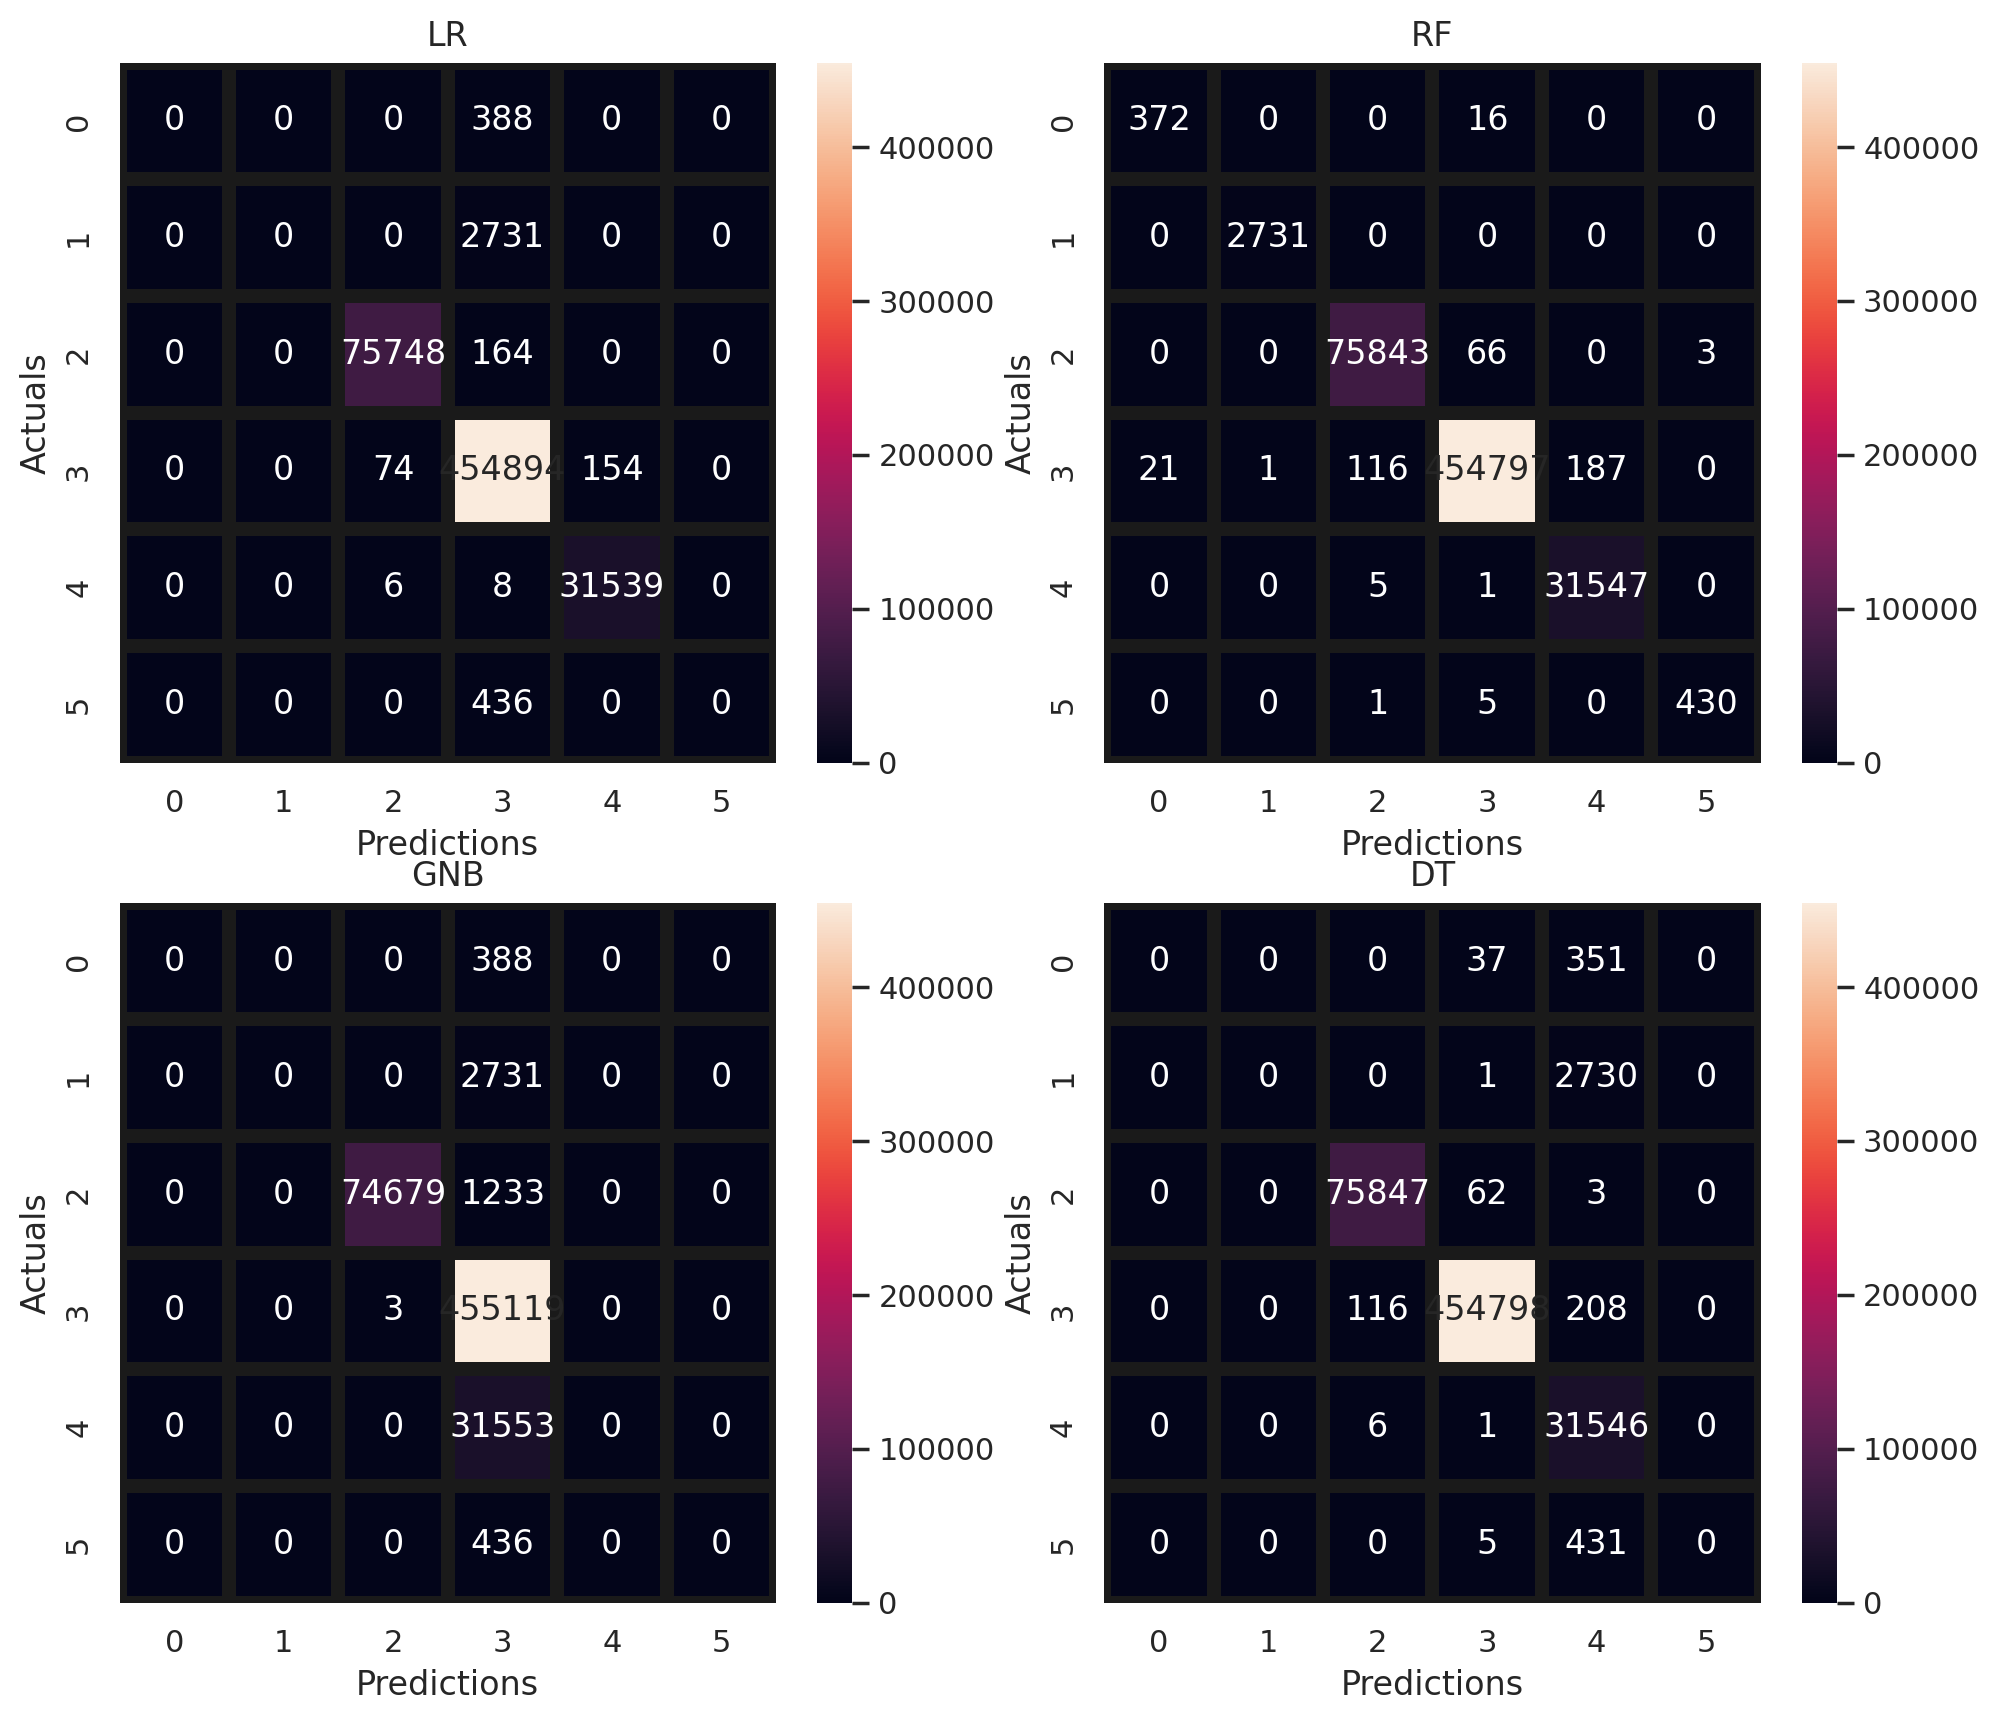

In [35]:
array1=[[     0,      0,      0,    388,      0,      0],
       [     0,      0,      0,   2731,      0,      0],
       [     0,      0,  75748,    164,      0,      0],
       [     0,      0,     74, 454894,    154,      0],
       [     0,      0,      6,      8,  31539,      0],
       [     0,      0,      0,    436,      0,      0]]
array2=[[   372,      0,      0,     16,      0,      0],
       [     0,   2731,      0,      0,      0,      0],
       [     0,      0,  75843,     66,      0,      3],
       [    21,      1,    116, 454797,    187,      0],
       [     0,      0,      5,      1,  31547,      0],
       [     0,      0,      1,      5,      0,    430]]
array3=[[     0,      0,      0,    388,      0,      0],
       [     0,      0,      0,   2731,      0,      0],
       [     0,      0,  74679,   1233,      0,      0],
       [     0,      0,      3, 455119,      0,      0],
       [     0,      0,      0,  31553,      0,      0],
       [     0,      0,      0,    436,      0,      0]]
array4=[[     0,      0,      0,     37,    351,      0],
       [     0,      0,      0,      1,   2730,      0],
       [     0,      0,  75847,     62,      3,      0],
       [     0,      0,    116, 454798,    208,      0],
       [     0,      0,      6,      1,  31546,      0],
       [     0,      0,      0,      5,    431,      0]]


i=1
def plot_sub_sentiment(Airline,A):
    sns.set()
    sns.heatmap(Airline,annot=True,fmt = "d",linecolor="k",linewidths=5)
    plt.title(A,fontsize=12)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')

plt.figure(1,figsize=(18, 10),dpi=200)
plt.subplot(231)
plot_sub_sentiment(array1,'LR')
plt.subplot(232)
plot_sub_sentiment(array2,'RF')
plt.subplot(234)
plot_sub_sentiment(array3,'GNB')
plt.subplot(235)
plot_sub_sentiment(array4,'DT')
# plt.savefig('dlcm.pdf')